In [1]:
import fitz  # PyMuPDF
import io  # To handle byte streams
from PIL import Image
import pytesseract
import pdfplumber
import json
import os

# Set Tesseract path (if necessary)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Default path for Colab

def extract_text(pdf_path):
    text_data = {}
    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages, start=1):
            text = page.extract_text()
            if text:
                text_data[page_num] = text.strip()
    return text_data

def extract_images_with_ocr(pdf_path, output_dir, ocr_lang="eng"):
    image_data = []
    doc = fitz.open(pdf_path)
    pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]

    os.makedirs(output_dir, exist_ok=True)

    for page_num in range(len(doc)):
        page = doc[page_num]
        images = page.get_images(full=True)
        for img_index, img in enumerate(images):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image = Image.open(io.BytesIO(image_bytes))

            ocr_text = pytesseract.image_to_string(image, lang=ocr_lang)

            img_info = {
                "page": page_num + 1,
                "width": image.width,
                "height": image.height,
                "image_index": img_index,
                "ext": base_image["ext"],
                "dpi": image.info.get("dpi", (72, 72)),
                "ocr_text": ocr_text.strip(),
                "image_path": f"{pdf_name}_page_{page_num + 1}_image_{img_index}.{base_image['ext']}"
            }
            image_data.append(img_info)

            img_filename = f"{pdf_name}_page_{page_num + 1}_image_{img_index}.{base_image['ext']}"
            img_path = os.path.join(output_dir, img_filename)
            image.save(img_path)
    return image_data

def save_to_json(output_path, text_data, image_data):
    data = {
        "text_data": text_data,
        "image_data": image_data,
    }
    with open(output_path, "w") as json_file:
        json.dump(data, json_file, indent=4)

def parse_pdfs(pdf_paths, base_output_dir, ocr_lang="eng"):
    for pdf_path in pdf_paths:
        pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
        output_dir = os.path.join(base_output_dir, pdf_name)
        output_json_path = os.path.join(output_dir, f"{pdf_name}_data.json")

        print(f"Processing PDF: {pdf_path}")
        os.makedirs(output_dir, exist_ok=True)

        text_data = extract_text(pdf_path)
        image_data = extract_images_with_ocr(pdf_path, output_dir, ocr_lang)

        save_to_json(output_json_path, text_data, image_data)
        print(f"Completed processing for {pdf_name}. Results saved to {output_json_path}.\n")

# Example Usage
if __name__ == "__main__":
    pdf_paths = [
        "Autodesk Inventor Practice Part Drawings.pdf",  # Ensure these names match your uploaded files
        "Engineering+Working+Drawing+Basics.pdf",
    ]
    base_output_dir = "extra_newdata"

    parse_pdfs(pdf_paths, base_output_dir, ocr_lang="eng")


Processing PDF: Autodesk Inventor Practice Part Drawings.pdf
Completed processing for Autodesk Inventor Practice Part Drawings. Results saved to extra_newdata\Autodesk Inventor Practice Part Drawings\Autodesk Inventor Practice Part Drawings_data.json.

Processing PDF: Engineering+Working+Drawing+Basics.pdf
Completed processing for Engineering+Working+Drawing+Basics. Results saved to extra_newdata\Engineering+Working+Drawing+Basics\Engineering+Working+Drawing+Basics_data.json.



In [2]:
import os
import json
import pandas as pd

pdf_paths = [
    r"C:\Users\Admin\Engineering_ai\EGchat\extra_newdata\Autodesk Inventor Practice Part Drawings",
    r"C:\Users\Admin\Engineering_ai\EGchat\extra_newdata\Engineering+Working+Drawing+Basics"
]

# Initialize lists to hold DataFrames
text_dfs = []
image_dfs = []

for i, path in enumerate(pdf_paths):
    # List all JSON files in the current directory
    for filename in os.listdir(path):
        if filename.endswith(".json"):
            json_file_path = os.path.join(path, filename)
            with open(json_file_path, "r") as f:
                data = json.load(f)

            # Access specific parts of the data to create DataFrames
            text_data = data.get("text_data", {})
            # Handle 'text_data': it's likely a dictionary with page numbers as keys and text as values.
            df_text = pd.DataFrame.from_dict(text_data, orient="index", columns=["Text"])
            df_text["source"] = f"doc{i}"
            text_dfs.append(df_text)

            image_data = data.get("image_data", [])
            # Handle 'image_data': likely a list of dictionaries where each dictionary represents an image.
            df_image = pd.DataFrame(image_data)
            df_image["source"] = f"doc{i}"
            image_dfs.append(df_image)

# Combine all text DataFrames into one
combined_text_df = pd.concat(text_dfs, ignore_index=True)

# Combine all image DataFrames into one
combined_image_df = pd.concat(image_dfs, ignore_index=True)

# Clean the text data
combined_text_df["Text"] = combined_text_df["Text"].str.lower()  # Convert text to lowercase
combined_text_df["Text"] = combined_text_df["Text"].str.replace("/n", " ", regex=False)  # Replace newline characters




In [3]:
import os
import numpy as np
import faiss
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load models for text and image embeddings
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Define the image directories
image_dirs = [
    r"C:\Users\Admin\Engineering_ai\EGchat\extra_newdata\Autodesk Inventor Practice Part Drawings",
    r"C:\Users\Admin\Engineering_ai\EGchat\extra_newdata\Engineering+Working+Drawing+Basics"
]

# Collect image paths
image_paths = []
for image_dir in image_dirs:
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('.jpeg', '.jpg', '.png')):
                image_paths.append(os.path.join(root, file))

# Function to generate embeddings for text using CLIP
def embedding_text(text):
    """Generate embeddings for text using CLIP."""
    # Truncate text to fit the model's maximum length
    inputs = clip_processor(text=[text], images=[Image.new("RGB", (224, 224))], return_tensors="pt", padding=True, truncation=True, max_length=77)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        text_embedding = outputs.text_embeds.numpy()  # Get the text embeddings
    return text_embedding

# Function to generate embeddings for images
def embedding_image(image_path):
    """Generate embeddings for an image using CLIP."""
    # Load image
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(text=[""], images=image, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        img_embedding = outputs.image_embeds.numpy()

    return img_embedding

# Generate embeddings for images
image_embeddings = np.array([embedding_image(img_path) for img_path in image_paths]).squeeze()

# Create vector database for image embeddings
def create_vector_database(embeddings):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings.astype(np.float32))
    return index

vector_db_image = create_vector_database(image_embeddings)

# Assuming collected_text DataFrame contains text data
# Replace 'collected_text' with your actual DataFrame name
document_texts = combined_text_df["Text"].tolist()  # Adjust column name as needed
document_embeddings = np.array([embedding_text(text) for text in document_texts]).squeeze()

# Create vector database for text embeddings
vector_db_text = create_vector_database(document_embeddings)

# Function to retrieve similar documents based on a query
def retrieve_similar_documents(query, vector_db, documents, k=5):
    """Retrieve top k similar documents based on a query."""
    query_embedding = embedding_text(query)  # Get the embedding for the query
    query_embedding = query_embedding.reshape(1, -1)  # Reshape for FAISS
    D, I = vector_db.search(query_embedding.astype(np.float32), k)
    return [documents[i] for i in I[0]]

# Example usage
query = "Tell me about the first document."
similar_texts = retrieve_similar_documents(query, vector_db_text, document_texts, k=2)
print("Similar Texts:", similar_texts)

# For images
similar_images = retrieve_similar_documents(query, vector_db_image, image_paths, k=2)
print("Similar Images:", similar_images)


c:\Users\Admin\Engineering_ai\EGchat\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

In [8]:
import json
import pandas as pd
import torch
import numpy as np
import faiss
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModel

# Load the CLIP model and processor for images
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Load the text model and tokenizer
text_model_name = "sentence-transformers/all-MiniLM-L6-v2"
text_model = AutoModel.from_pretrained(text_model_name)
tokenizer = AutoTokenizer.from_pretrained(text_model_name)

c:\Users\Admin\Engineering_ai\EGchat\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
import numpy as np
import faiss
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Define the image directories
image_dirs = [
    r"C:\Users\Admin\Engineering_ai\EGchat\extra_newdata\Autodesk Inventor Practice Part Drawings",
    r"C:\Users\Admin\Engineering_ai\EGchat\extra_newdata\Engineering+Working+Drawing+Basics"
]

# Collect image paths
image_paths = []
for image_dir in image_dirs:
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('.jpeg', '.jpg', '.png')):
                image_paths.append(os.path.join(root, file))

# Function to generate embeddings for text using CLIP
def embedding_text(text):
    """Generate embeddings for text using CLIP."""
    # Truncate text to fit the model's maximum length
    inputs = clip_processor(text=[text], images=[Image.new("RGB", (224, 224))], return_tensors="pt", padding=True, truncation=True, max_length=77)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        text_embedding = outputs.text_embeds.numpy()  # Get the text embeddings
    return text_embedding

# Function to generate embeddings for images
def embedding_image(image_path):
    """Generate embeddings for an image using CLIP."""
    # Load image
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(text=[""], images=image, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        img_embedding = outputs.image_embeds.numpy()

    return img_embedding

# Generate embeddings for images
image_embeddings = np.array([embedding_image(img_path) for img_path in image_paths]).squeeze()

# Create vector database for image embeddings
def create_vector_database(embeddings):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings.astype(np.float32))
    return index

vector_db_image = create_vector_database(image_embeddings)

# Assuming collected_text DataFrame contains text data
# Replace 'collected_text' with your actual DataFrame name
document_texts = combined_text_df["Text"].tolist()  # Adjust column name as needed
document_embeddings = np.array([embedding_text(text) for text in document_texts]).squeeze()

# Create vector database for text embeddings
vector_db_text = create_vector_database(document_embeddings)

# Function to retrieve similar documents based on a query
def retrieve_similar_documents(query, vector_db, documents, k=5):
    """Retrieve top k similar documents based on a query."""
    query_embedding = embedding_text(query)  # Get the embedding for the query
    query_embedding = query_embedding.reshape(1, -1)  # Reshape for FAISS
    D, I = vector_db.search(query_embedding.astype(np.float32), k)
    return [documents[i] for i in I[0]]

# Example usage
query = "Tell me about the first document."
similar_texts = retrieve_similar_documents(query, vector_db_text, document_texts, k=2)
print("Similar Texts:", similar_texts)

# For images
similar_images = retrieve_similar_documents(query, vector_db_image, image_paths, k=2)
print("Similar Images:", similar_images)


In [73]:
import numpy as np
import faiss

# Save the text vector database
faiss.write_index(vector_db_text, "vector_db_text.index")

# Save the image vector database
faiss.write_index(vector_db_image, "vector_db_image.index")

# Optionally, save the corresponding document texts and image paths for reference
np.save("document_texts.npy", document_texts)
np.save("image_paths.npy", image_paths)

Based on the provided texts, it seems like you're asking about a Richard Wheel with specific dimensions and features. Here are the key points from the texts:

1. The wheel has a diameter that varies based on its location, with options for r6, r8, and 100mm.
2. The wheel's diameter should be centered at 100mm, and it should align with blocks A and B, which are coincident with both corners at 37 and 13mm.
3. There is a 45mm diameter slot (cid:72) that is 18mm from the edge.
4. The wheel has a chamfer detail B of 10mm x 45mm.
5. All dimensions are given in millimeters.
6. The wheel is associated with sheets 16 of 25 and 3 of 25, and it has an alignment catch and a bottom fixture.
7. There is also a mount bracket (.ipt) with hardware and a bracket.

As for the diagrams, unfortunately, I cannot directly access or display the images you provided. However, based on the file names, it seems like they are pages from the "Autodesk Inventor Practice Part Drawings" document. Based on the file name

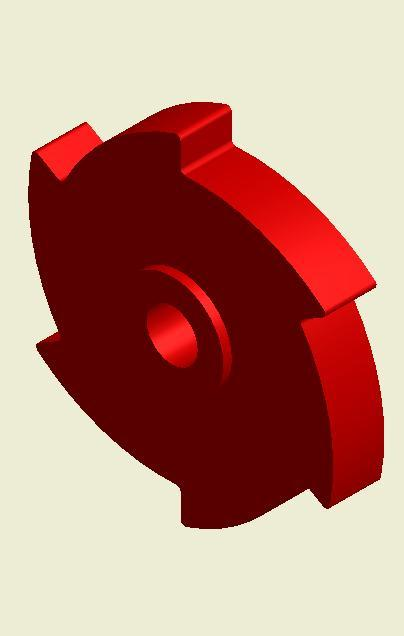

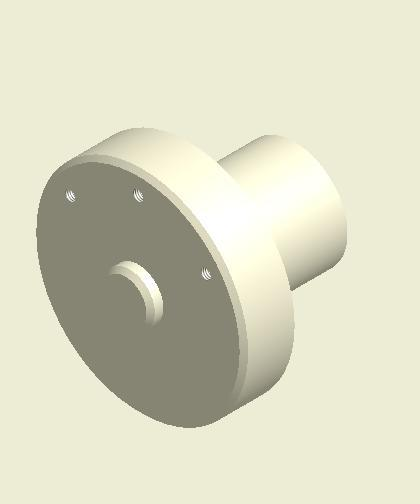

In [80]:
from langchain import LLMChain, ConversationChain
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains import SequentialChain
from PIL import Image
import IPython.display as display


llm = ChatGroq(
    model="mixtral-8x7b-32768",
    api_key="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",
    temperature=0.6,

)

prompt_template = PromptTemplate(
    input_variables=["query", "similar_texts", "similar_images"],
    template="""
    You are a knowledgeable assistant that provides detailed and relevant information based on user queries related to engineering diagrams and texts.

    Query: {query}

    Here are some related texts:
    {similar_texts}

    Here are some related images (diagrams):
    {similar_images}

    Your response should include the following:
    1. Summarize the key points from the related texts.
    2. Describe any relevant diagrams, including their purpose and context.
    3. If the query specifically asks for a diagram, prioritize presenting the relevant diagrams first.
    4. If there are no relevant images or texts, clearly state that you couldn't find any information.

    Please provide a concise and informative response that directly addresses the user's query, incorporating both text and diagram insights when applicable.
    """
)


# Create the conversation chain
chain = LLMChain(llm=llm, prompt=prompt_template)

def chatbot(query):
    # Retrieve similar texts
    similar_texts = retrieve_similar_documents(query, vector_db_text, document_texts, k=2)

    # Retrieve similar images
    similar_images = retrieve_similar_documents(query, vector_db_image, image_paths, k=2)

    # Format the results
    similar_texts_formatted = "\n".join(similar_texts) if similar_texts else "No relevant texts found."
    similar_images_formatted = "\n".join(similar_images) if similar_images else "No relevant images found."

    # Generate a response using the LLM
    response = chain.run(query=query, similar_texts=similar_texts_formatted, similar_images=similar_images_formatted)

    # Display the response
    print(response)

    # Show the images if any
    if similar_images:
        for img_path in similar_images:
            img = Image.open(img_path)
            display.display(img)  # Display the image

# Example usage


query = "discripre richart wheel "
response = chatbot(query)